# Import

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/drive/MyDrive/CS331

/content/drive/MyDrive/CS331


In [ ]:
import os
import cv2
import pickle
import tensorflow
import numpy as np
import mediapipe as mp
from tensorflow import keras
from scipy.spatial import distance
from google.colab.patches import cv2_imshow
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates

# CROP FACE

In [ ]:
def cropFace(image):
    with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5) as face_detection:
        # Read image
        imageRows, imageCols, _ = image.shape
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        for detection in results.detections:
            relativeBoundingBox = detection.location_data.relative_bounding_box

            rectStartPoint = _normalized_to_pixel_coordinates(
                                        relativeBoundingBox.xmin, 
                                        relativeBoundingBox.ymin, 
                                        imageCols,
                                        imageRows)
            
            rectEndPoint = _normalized_to_pixel_coordinates(
                                        relativeBoundingBox.xmin + relativeBoundingBox.width,
                                        relativeBoundingBox.ymin + relativeBoundingBox.height, 
                                        imageCols,
                                        imageRows)
            
            xLeft, yTop = rectStartPoint
            xRight, yBot = rectEndPoint

            cropImage = image[yTop: yBot, xLeft: xRight]
        return cropImage

In [ ]:
def displayText(text, image, height): 
    # Draw rectangle
    overlayImage = image.copy()
    h, w, _ = image.shape
    cv2.rectangle(overlayImage, (0, h-height), (w, h), (255,0,0), -1)
    cv2.addWeighted(overlayImage, 0.5, image, 1 - 0.5, 0, image)

    tempRectangle = np.zeros((h - (h-height), w, 3), np.uint8)

    font = cv2.FONT_HERSHEY_SIMPLEX

    # get boundary of this text
    textsize = cv2.getTextSize(text, font, 1, 2)[0]

    # get coords based on boundary
    textX = (tempRectangle.shape[1] - textsize[0]) // 2
    textY = (tempRectangle.shape[0] + textsize[1]) // 2

    # Get coords based on boundary
    textX = (tempRectangle.shape[1] - textsize[0]) // 2

    # Add text centered on image
    cv2.putText(image, text, (textX, textY + (h-height)), font, 1, (255, 255, 255), 2)

In [ ]:
def myFaceCropPredict(image, model):
    shapes = ['heart', 'oblong', 'oval', 'round', 'square']
    # Crop face
    cropImage = cropFace(image)

    if not type:
        cropImage = cv2.cvtColor(cropImage, cv2.COLOR_BGR2GRAY)

    # Resize
    cropResize = cv2.resize(cropImage, (224, 224))
    input = cropResize.copy()

    # Modify input
    modifedInput = np.array(input)
    modifedInput = np.expand_dims(modifedInput, axis=0)

    zScores = model.predict(modifedInput)
    yPred = np.argmax(zScores, axis=1)

    yLabel = shapes[yPred[0]]
    # Display
    displayText(yLabel, image, image.shape[1]//5)
    cv2_imshow(image)


# DEMO

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/CS331/FaceOnly/VGG16/checkpoint/model-06-0.78.h5')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

1/1 [==============================] - 1s 556ms/step


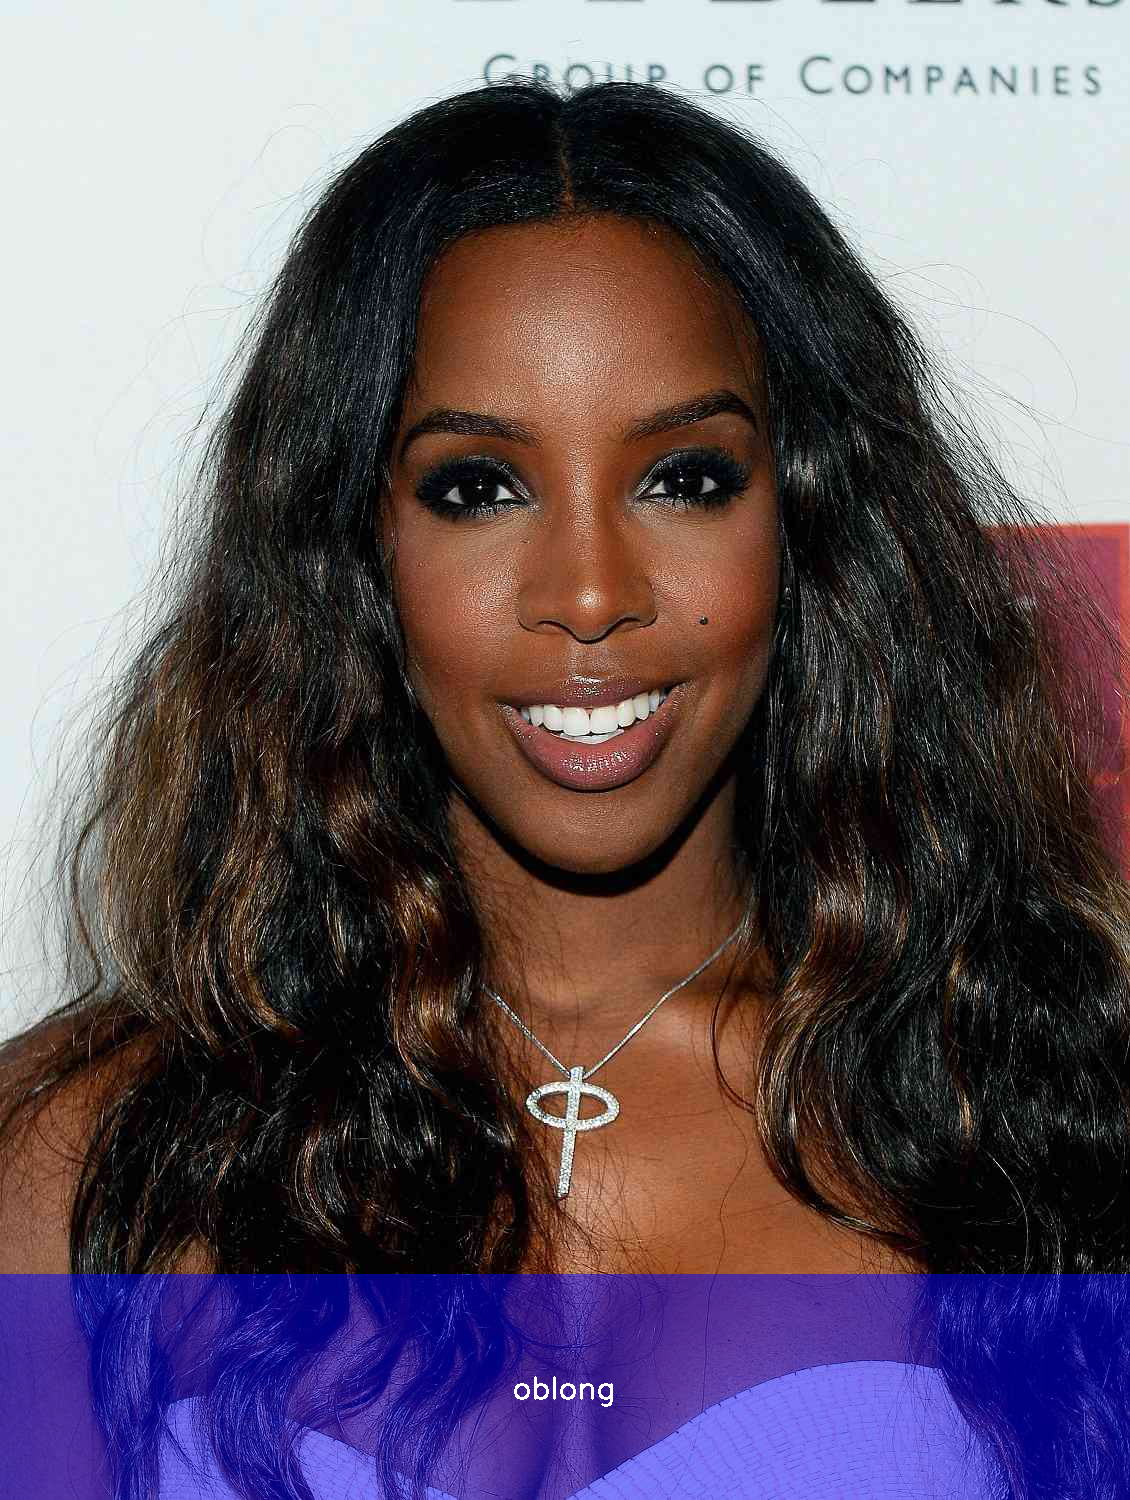

In [ ]:
image = cv2.imread('/content/drive/MyDrive/CS331/photo.jpg')
myFaceCropPredict(image, model)